In [ ]:
y_gb = optimizer.predict(X_test)

In [ ]:
f1_score(y_test, y_gb, average = 'weighted')

0.8179754487693542

Zespoły klasyfikatorów
----

In [1]:
!git clone https://github.com/matzim95/ML-datasets


fatal: destination path 'ML-datasets' already exists and is not an empty directory.


In [54]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'breast_cancer': {'class_column': 'Class', 'index_col': 'Sample code number'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [3]:
X, y, classes = prepare_dataset('wine')

In [4]:
classes

array(['one', 'two', 'three'], dtype=object)

Bagging
---

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer, StandardScaler


In [6]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

## Testy na zbiorach danych

In [7]:

def preprocess_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM (confusion matrix)
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [9]:
load_dataset('breast_cancer', 'Class')

(     Sample code number  Clump Thickness  Uniformity of Cell Size  \
 0               1000025                5                        1   
 1               1002945                5                        4   
 2               1015425                3                        1   
 3               1016277                6                        8   
 4               1017023                4                        1   
 ..                  ...              ...                      ...   
 694              776715                3                        1   
 695              841769                2                        1   
 696              888820                5                       10   
 697              897471                4                        8   
 698              897471                4                        8   
 
      Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
 0                           1                  1                           

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malic acid                    178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity of ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  OD280/OD315 of diluted wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

In [11]:
X, y, classes = prepare_dataset('breast_cancer')
X = X.replace('?',np.NaN)
X['Bare Nuclei'] = X['Bare Nuclei'].fillna(X['Bare Nuclei'].median())
X = preprocess_data(X, standarizer)
X.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02
mean,1.655011e-16,-2.801765e-16,-5.854481e-16,-1.477121e-16,-1.021199e-15,7.026648e-16,6.251556e-16,3.874662e-16,7.093356e-16
std,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00
min,-1.214667e+00,-6.999951e-01,-7.432990e-01,-6.332472e-01,-1.001495e+00,-6.869792e-01,-1.000471e+00,-6.118250e-01,-3.439118e-01
25%,-8.592662e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-5.900668e-01,-6.118250e-01,-3.439118e-01
50%,-1.484649e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-1.796621e-01,-6.118250e-01,-3.439118e-01
75%,5.623364e-01,6.117919e-01,6.035993e-01,4.181537e-01,3.543054e-01,4.181956e-01,6.411472e-01,3.713145e-01,-3.439118e-01
max,1.983939e+00,2.251526e+00,2.287222e+00,2.520955e+00,3.065906e+00,1.799664e+00,2.693171e+00,2.337594e+00,4.907421e+00


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [13]:

print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

0    458
1    241
Name: class, dtype: int64
0    366
1    193
Name: class, dtype: int64
0    92
1    48
Name: class, dtype: int64


In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [15]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

In [16]:
print_results(calculate_metrics(y_tree, y_test), 'tree')

Results for tree
----
  Accuracy:  0.9142857142857143
  Precision: 0.899909420289855
  Recall:    0.9084181313598519
  F1 score:  0.9039121482498285
  Mislabeled 12 out of 140




In [17]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_LR = LR.predict(X_test)

In [18]:
print_results(calculate_metrics(y_LR, y_test), 'tree')

Results for tree
----
  Accuracy:  0.95
  Precision: 0.9420289855072463
  Recall:    0.9465797300388927
  F1 score:  0.9442389758179233
  Mislabeled 7 out of 140




Results for Decision Tree
----
  Accuracy:  0.9142857142857143
  Precision: 0.9084181313598519
  Recall:    0.899909420289855
  F1 score:  0.9039121482498285
  Mislabeled 12 out of 140




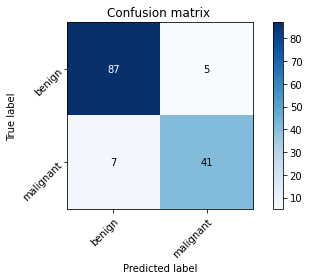

In [19]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

In [20]:
bclf = BaggingClassifier(base_estimator = SVC())
bclf.fit(X_train, y_train)
y_b = bclf.predict(X_test)

Results for Bagging Ensemble
----
  Accuracy:  0.9571428571428572
  Precision: 0.9524456521739131
  Recall:    0.9524456521739131
  F1 score:  0.9524456521739131
  Mislabeled 6 out of 140




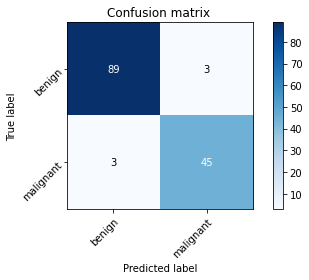

In [21]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensemble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)

In [22]:
print(bclf.estimators_)

[SVC(random_state=1518830896), SVC(random_state=781591246), SVC(random_state=1235447983), SVC(random_state=524699031), SVC(random_state=1518376423), SVC(random_state=1709119237), SVC(random_state=1275805814), SVC(random_state=107367021), SVC(random_state=2086096673), SVC(random_state=1906326713)]


In [23]:
from sklearn.model_selection import KFold, StratifiedKFold

def cross_validate1(classifier, kfold, X, y, classes, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm),
                              classes,
                              title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

In [24]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(bclf, X, y, cv=10)
cv_results_tree = cross_validate(tree, X, y, cv=10)

In [25]:
print(cv_results['test_score'])
print(cv_results_tree['test_score'])

[0.9        0.97142857 0.97142857 0.91428571 0.98571429 0.97142857
 0.97142857 1.         0.98571429 0.98550725]
[0.9        0.91428571 0.95714286 0.9        0.94285714 0.95714286
 0.94285714 0.97142857 0.95714286 0.98550725]


Results for DecisionTreeClassifier
----
  Accuracy:  0.944206008583691
  Precision: 0.9365207559360362
  Recall:    0.9407128232075233
  F1 score:  0.9385538828419253
  Mislabeled 39 out of 699




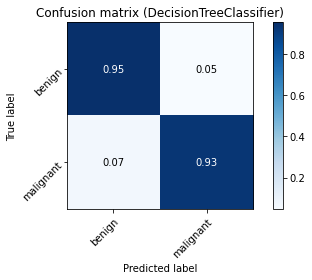

In [26]:
cross_validate1(DecisionTreeClassifier, StratifiedKFold(10), X, y, classes)

Results for BaggingClassifier
----
  Accuracy:  0.9542203147353362
  Precision: 0.9493377303448152
  Recall:    0.9493377303448152
  F1 score:  0.9493377303448152
  Mislabeled 32 out of 699




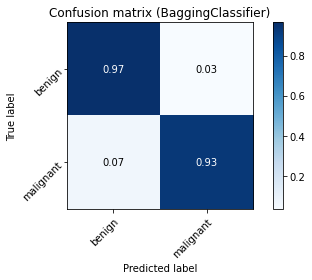

In [27]:
cross_validate1(BaggingClassifier, StratifiedKFold(10), X, y, classes)

Zad.1. Zapoznaj się z kodem i colabem oraz sprobuj wykonac klasyfikacje na zbiorze breast_cancer.csv. Zakoduj lub usun znak zapytania w kolumnie bare_nuclei.
Wypróuj 2 znane  CI pojedyncze klasyfikatory oraz BaggingClassifier. Jako rezultat wyświetl f1_score dla wszystkich algorytmów.

Random Forest
----

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()

rfclf.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
y_rf = rfclf.predict(X_test)

In [30]:
print(rfclf.estimators_)

[DecisionTreeClassifier(max_features='auto', random_state=400446065), DecisionTreeClassifier(max_features='auto', random_state=66893395), DecisionTreeClassifier(max_features='auto', random_state=1057365252), DecisionTreeClassifier(max_features='auto', random_state=1444162464), DecisionTreeClassifier(max_features='auto', random_state=1468889100), DecisionTreeClassifier(max_features='auto', random_state=530414164), DecisionTreeClassifier(max_features='auto', random_state=2023761392), DecisionTreeClassifier(max_features='auto', random_state=1609053986), DecisionTreeClassifier(max_features='auto', random_state=1811306661), DecisionTreeClassifier(max_features='auto', random_state=54632264), DecisionTreeClassifier(max_features='auto', random_state=2071895506), DecisionTreeClassifier(max_features='auto', random_state=1086619978), DecisionTreeClassifier(max_features='auto', random_state=1231395809), DecisionTreeClassifier(max_features='auto', random_state=1174176793), DecisionTreeClassifier(ma

Results for RF Ensemble
----
  Accuracy:  0.95
  Precision: 0.9465797300388927
  Recall:    0.9420289855072463
  F1 score:  0.9442389758179233
  Mislabeled 7 out of 140




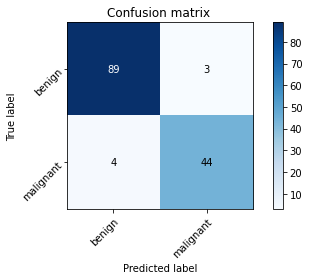

In [31]:
print_results(calculate_metrics(y_test.values, y_rf), 'RF Ensemble')
cm = confusion_matrix(y_test, y_rf)
plot_confusion_matrix(cm, classes)

Results for RandomForestClassifier
----
  Accuracy:  0.9670958512160229
  Precision: 0.9631716006293289
  Recall:    0.9640779865552919
  F1 score:  0.9636221701795473
  Mislabeled 23 out of 699




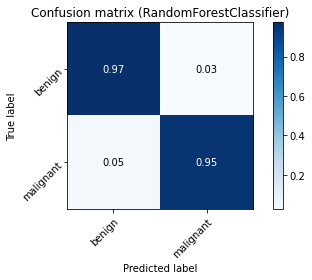

In [32]:
cross_validate1(RandomForestClassifier, StratifiedKFold(10), X, y, classes)

In [33]:
cross_validate_rf = cross_validate(rfclf, X, y, cv=10)
print(cross_validate_rf['test_score'])
print(np.mean(cross_validate_rf['test_score']))

[0.91428571 0.97142857 0.97142857 0.91428571 0.98571429 0.98571429
 0.97142857 0.98571429 0.98571429 1.        ]
0.9685714285714286


In [34]:
f1_score(y_test, y_rf)

0.9263157894736843

Zad.2. Wykonaj random forest na tym samym zbiorze danych co w zadaniu 1 (breast_cancer.csv) i zwróc uwagę na liczbe estimatorów i parametry typowo drzewiaste (min_samples_split, min_samples_leaf, max_depth, criterion) - sprobuj wybrac mozliwie najlepsze. Jako rezultat zapisz f1_score na zb testowym oraz sredni wynik z testowych score crooss walidacji (np.mean(cross_validate_rf['test_score']))

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10,50,100],
              'min_samples_leaf': [5,10,20],
              'max_leaf_nodes': [8, 16,32]
              }

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()

optimizer = GridSearchCV(rnd_clf,
                         param_grid,
                         scoring='accuracy')

optimizer.fit(X_train, y_train)

y_rnd = optimizer.predict(X_test)

In [40]:
cross_validate_rnd = cross_validate(optimizer, X, y, cv=5)
np.mean(cross_validate_rnd)

TypeError: ignored

In [39]:
f1_score(y_test, y_rnd)

0.9387755102040817

Ada Boost Classifier


In [41]:
from sklearn.ensemble import AdaBoostClassifier
abclf = AdaBoostClassifier(n_estimators = 50)
abclf.fit(X_train, y_train)

AdaBoostClassifier()

In [42]:
y_ab = abclf.predict(X_test)

Results for AdaBoost Ensemble
----
  Accuracy:  0.9428571428571428
  Precision: 0.940795559666975
  Recall:    0.9316123188405797
  F1 score:  0.9359414321665522
  Mislabeled 8 out of 140




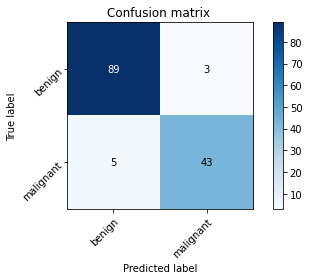

In [43]:
print_results(calculate_metrics(y_test.values, y_ab), 'AdaBoost Ensemble')
cm = confusion_matrix(y_test, y_ab)
plot_confusion_matrix(cm, classes)

In [44]:
#cross_validate(abclf, StratifiedKFold(10), X, y, classes)

In [45]:
from sklearn.model_selection import cross_validate

In [46]:
cv_results = cross_validate(abclf, X,y, cv=10)

In [47]:
cv_results['test_score']

array([0.85714286, 0.95714286, 0.97142857, 0.91428571, 0.97142857,
       0.97142857, 0.95714286, 1.        , 0.98571429, 0.95652174])

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
gbclf = GradientBoostingClassifier(n_estimators = 50)
gbclf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

In [50]:
y_gb = gbclf.predict(X_test)

Results for GradientBoosting Ensemble
----
  Accuracy:  0.9428571428571428
  Precision: 0.9365942028985508
  Recall:    0.9365942028985508
  F1 score:  0.9365942028985508
  Mislabeled 8 out of 140




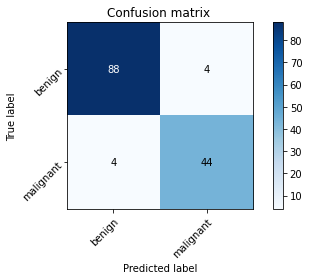

In [51]:
print_results(calculate_metrics(y_test.values, y_gb), 'GradientBoosting Ensemble')
cm = confusion_matrix(y_test, y_gb)
plot_confusion_matrix(cm, classes)

In [52]:
cv_results = cross_validate(gbclf, X,y, cv=10)

In [53]:
cv_results['test_score']

array([0.88571429, 0.94285714, 0.97142857, 0.91428571, 0.97142857,
       0.95714286, 0.97142857, 0.98571429, 0.98571429, 0.98550725])

Zad.3. Uzyj zbioru glass i wykonaj na nim uczenie wszystkimi poznanymi (gradient boosting, ada boost, random forest) dziś algorytmami, poustawiaj parametry dla tych algorytmów jak również dla estymatorów bazowych np. SVM(C=10, gamma=0.001), tak aby osiągnąc możliwe najlepszy f1_score, mean(cv_test_score). Zapisz wyniki dla najlepszego.

In [110]:
X, y, classes = prepare_dataset('glass')
X = preprocess_data(X, standarizer)
X.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02
mean,-2.877449e-14,2.179980e-15,-2.801497e-16,-3.434428e-16,9.966067e-16,7.470660e-17,-3.137418e-16,-1.763906e-16,-6.121791e-17
std,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00
min,-2.381516e+00,-3.286943e+00,-1.865511e+00,-2.318616e+00,-3.676472e+00,-7.639186e-01,-2.484084e+00,-3.528768e-01,-5.864509e-01
25%,-6.082728e-01,-6.141580e-01,-3.957744e-01,-5.117560e-01,-4.800288e-01,-5.756501e-01,-5.049657e-01,-3.528768e-01,-5.864509e-01
50%,-2.262293e-01,-1.323817e-01,5.527787e-01,-1.704602e-01,1.799655e-01,8.905322e-02,-2.514132e-01,-3.528768e-01,-5.864509e-01
75%,2.614331e-01,5.120326e-01,6.361680e-01,3.715977e-01,5.649621e-01,1.735820e-01,1.518057e-01,-3.528768e-01,4.422417e-01
max,5.137232e+00,4.875637e+00,1.254639e+00,4.125851e+00,3.570524e+00,8.780145e+00,5.094318e+00,5.997210e+00,4.659881e+00


In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50,100,500],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3,5]
              }

gbclf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 5)

optimizer = GridSearchCV(gbclf,
                         param_grid,
                         scoring='accuracy')

#gbclf.fit(X_train, y_train)

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100],
              'learning_rate': [0.1, 1],
              'max_depth': [3, 5]
              }

gbclf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 5)

optimizer = GridSearchCV(gbclf,
                         param_grid,
                         scoring='accuracy')

optimizer.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(max_depth=5),
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

In [114]:
y_gb = optimizer.predict(X_test)

In [115]:
f1_score(y_test, y_gb, average = 'weighted')

0.7244014205521824

In [116]:
results_gb = cross_validate(optimizer, X,y, cv=9)
results_gb['test_score']

array([0.75      , 0.79166667, 0.79166667, 0.75      , 0.70833333,
       0.83333333, 0.58333333, 0.60869565, 0.69565217])

In [117]:
np.mean(results_gb['test_score'])

0.7236312399355876

In [118]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1, 10]
              }

adclf = AdaBoostClassifier(n_estimators = 100, learning_rate = 1)

optimizer = GridSearchCV(adclf,
                         param_grid,
                         scoring='accuracy')

optimizer.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(learning_rate=1, n_estimators=100),
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [119]:
y_ab = optimizer.predict(X_test)

In [120]:
f1_score(y_test, y_ab, average = 'weighted')

0.46931296233621816

In [121]:
results_ab = cross_validate(optimizer, X,y, cv=9)
results_ab['test_score']

array([0.375     , 0.45833333, 0.625     , 0.54166667, 0.45833333,
       0.45833333, 0.54166667, 0.52173913, 0.69565217])

In [122]:
np.mean(results_ab['test_score'])

0.5195249597423509

In [123]:
|

SyntaxError: ignored